Simulator Validation
-------------------

When reassortment is turned off, the simulator should draw trees from a standard coalescent distribution.  We can test this by comparing tree heights and lengths between our simulator and the regular RandomTree simulator under various population functions.

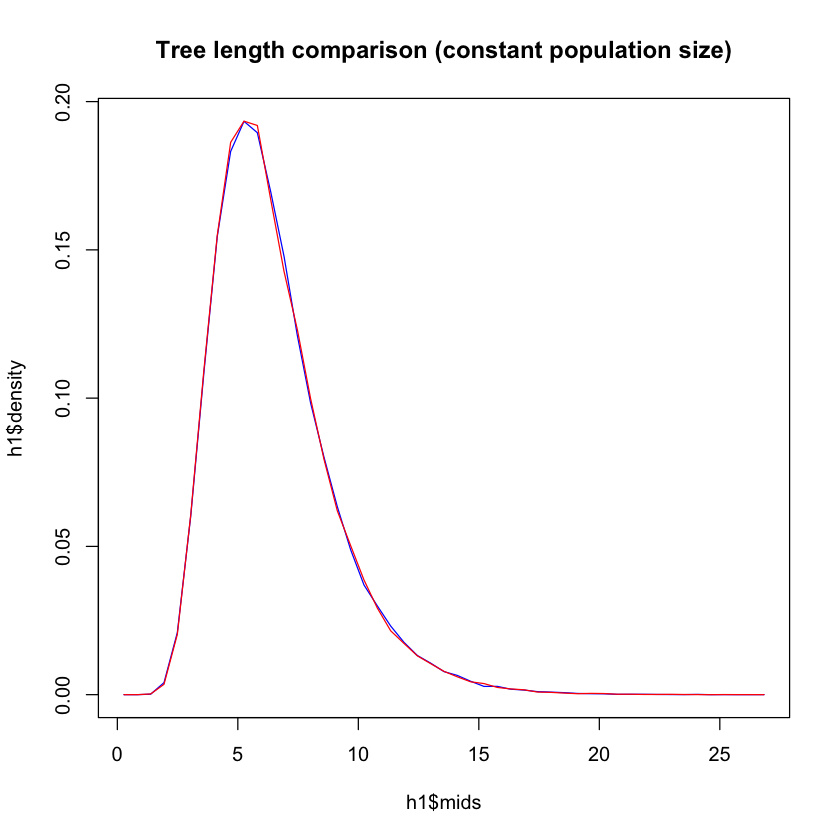

In [16]:
df <- read.table("simulator/simulate_without_reassortment.log", header=T)

maxLength <- max(df$simulated_network.totalLength,
                df$simulated_tree.treeLength)
breaks <- seq(0, maxLength, length.out=50)

h1 <- hist(df$simulated_network.totalLength, plot=F,
          breaks=breaks)
h2 <- hist(df$simulated_tree.treeLength, plot=F,
          breaks=breaks)

plot(h1$mids, h1$density, 'l', col='blue',
    main="Tree length comparison (constant population size)")
lines(h2$mids, h2$density, col='red')

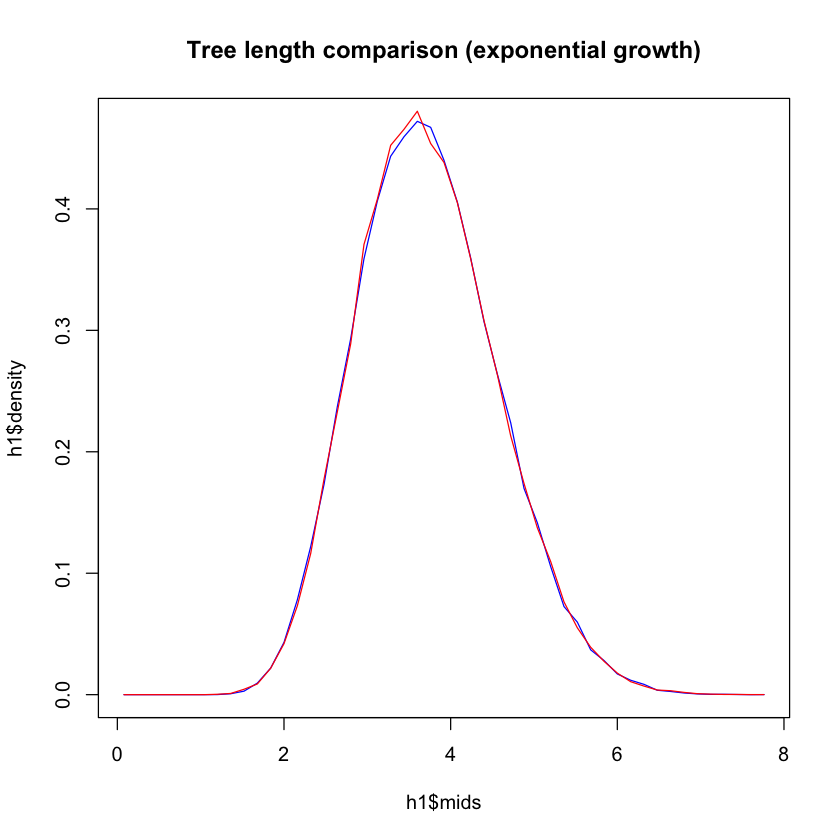

In [17]:
df <- read.table("simulator/simulate_without_reassortment_expGrowth.log", header=T)

maxLength <- max(df$simulated_network.totalLength,
                df$simulated_tree.treeLength)
breaks <- seq(0, maxLength, length.out=50)

h1 <- hist(df$simulated_network.totalLength, plot=F,
          breaks=breaks)
h2 <- hist(df$simulated_tree.treeLength, plot=F,
          breaks=breaks)

plot(h1$mids, h1$density, 'l', col='blue',
    main="Tree length comparison (exponential growth)")
lines(h2$mids, h2$density, col='red')